In [1]:
import os
os.chdir("..")
!pwd

/datasets/home/home-00/10/410/rcgonzal/DSC180Malware/m2v-adversarial-hindroid


In [3]:
!pip install stellargraph
!pip install p_tqdm

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML
from gensim.models import Word2Vec
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph, IndexedArray
import json
from collections import defaultdict
from p_tqdm import p_umap


%matplotlib inline

In [2]:
dataset = datasets.BlogCatalog3()
display(HTML(dataset.description))
g = dataset.load()
print(
    "Number of nodes {} and number of edges {} in graph.".format(
        g.number_of_nodes(), g.number_of_edges()
    )
)

Number of nodes 10351 and number of edges 348459 in graph.


In [11]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["user", "group", "user"],
    ["user", "group", "user", "user"],
    ["user", "user"],
]

In [12]:
UniformRandomMetaPathWalk?

In [7]:
# Create the random walker
rw = UniformRandomMetaPathWalk(g)

walks = rw.run(
    nodes=list(g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 30936


UniformRandomMetaPathWalk algorithm:

Given:
- $n$ walks per node
- length of each random walk
- a list of metapaths
- a list of nodes

for each node

    for each metapath
    
    metapath = metapath[1:] * ((length // (len(metapath) - 1)) + 1)
    
        for n walks:
        
            for d in length:
            
                record current node
                
                find neighbors of current node of type metapath[d]
                
                randomly select new node from neighbors
                

In [14]:
%%timeit -n 1
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=9, iter=1)
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

NameError: name 'walks' is not defined

In [2]:
from dask.distributed import Client
import dask.dataframe as dd
import os
import pandas as pd
import numpy as np
from stellargraph import StellarGraph, IndexedArray
from stellargraph.data import UniformRandomMetaPathWalk
from gensim.models import Word2Vec

client = Client()

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
path = os.path.join('data/out/random-apps/', '*.csv')
data = dd.read_csv(path)

In [4]:
apps = data.app.unique().compute()
apps = apps.to_frame()
apps['uid'] = 'app' + pd.Series(apps.index).astype(str)
apps = apps.set_index('app')
apps

,uid
app,
academia_en_tu_movil.test_guarda_rural,app0
air.G2JWeirdKittyRescue,app1
air.com.adobe.example.gqbars,app2
air.com.eeco.blocknflick,app3
air.com.inline.jyoyuuman1,app4
...,...
sl_christmas_free.livewallpaper,app227
taha.islam.renewal,app228
toolbox.m.incoming.stop,app229


In [5]:
apis = data.api.unique().compute()
apis = apis.to_frame()
apis['uid'] = 'api' + pd.Series(apis.index).astype(str)
apis = apis.set_index('api')
apis

,uid
api,
Landroidx/core/graphics/drawable/IconCompatParcelizer;-><init>()V,api0
Landroidx/core/graphics/drawable/IconCompatParcelizer;->read(Landroidx/versionedparcelable/a;)Landroidx/core/graphics/drawable/IconCompat;,api1
Landroidx/core/graphics/drawable/IconCompatParcelizer;->write(Landroidx/core/graphics/drawable/IconCompat;Landroidx/versionedparcelable/a;)V,api2
Landroidx/core/app/RemoteActionCompatParcelizer;-><init>()V,api3
Landroidx/core/app/RemoteActionCompatParcelizer;->read(Landroidx/versionedparcelable/a;)Landroidx/core/app/RemoteActionCompat;,api4
...,...
Lvpn/free/preinicio$enviarTask;-><init>(Lvpn/free/preinicio;Lvpn/free/preinicio$1;)V,api1410883
Lvpn/free/preinicio$enviarTask;->execute([Ljava/lang/Object;)Landroid/os/AsyncTask;,api1410884
Lvpn/free/privados;->access$200(Lvpn/free/privados;)I,api1410885


In [6]:
app_api_edges = data[['app', 'api']].drop_duplicates().compute()
app_api_edges['app'] = app_api_edges['app'].map(apps.uid)
app_api_edges['api'] = app_api_edges['api'].map(apis.uid)
app_api_edges

,app,api
0,app0,api0
1,app0,api1
2,app0,api2
3,app0,api3
4,app0,api4
...,...,...
2597,app231,api1410884
2604,app231,api1410885
2605,app231,api1410886
2612,app231,api1410887


In [7]:
edges = app_api_edges
edges.columns = ['source', 'target']
edges = edges.reset_index(drop=True)
edges

,source,target
0,app0,api0
1,app0,api1
2,app0,api2
3,app0,api3
4,app0,api4
...,...,...
5473933,app231,api1410884
5473934,app231,api1410885
5473935,app231,api1410886
5473936,app231,api1410887


In [10]:
g = StellarGraph(nodes = {
    'app': IndexedArray(index=apps.uid),
    'api': IndexedArray(index=apis.uid)
},
                 edges = edges)

In [13]:
walk_length = 50  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["app", "api", "app"],
    [app, api, method, api, app]
]

# Create the random walker
rw = UniformRandomMetaPathWalk(g)

walks = rw.run(
    nodes=list(apps.uid),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=9, iter=1)
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(5898, 128)

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import display, HTML

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [15]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [g.node_type(node_id) for node_id in node_ids]

In [16]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

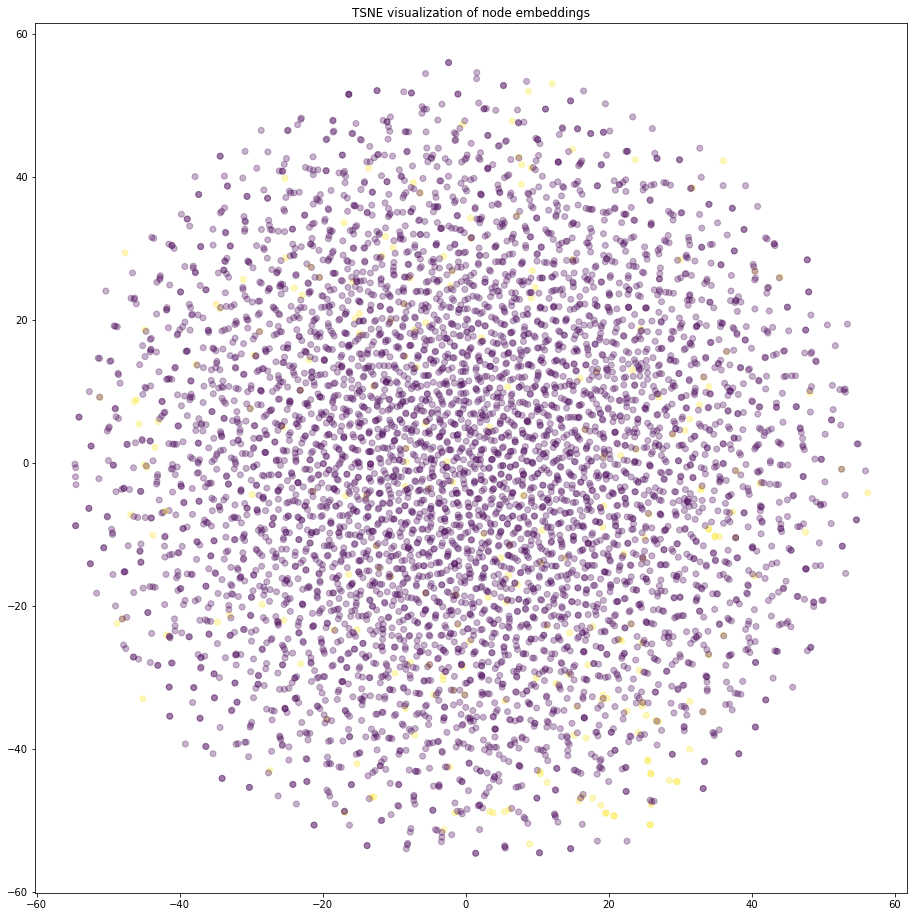

In [19]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [20]:
data.head()

,app,api,invoke_type,class,method,package,context
0,academia_en_tu_movil.test_guarda_rural,Landroidx/core/graphics/drawable/IconCompatPar...,direct,Landroid/support/v4/graphics/drawable/IconComp...,Landroid/support/v4/graphics/drawable/IconComp...,Landroidx/core/graphics/drawable,"invoke-direct {p0}, Landroidx/core/graphics/dr..."
1,academia_en_tu_movil.test_guarda_rural,Landroidx/core/graphics/drawable/IconCompatPar...,static,Landroid/support/v4/graphics/drawable/IconComp...,Landroid/support/v4/graphics/drawable/IconComp...,Landroidx/core/graphics/drawable,"invoke-static {p0}, Landroidx/core/graphics/dr..."
2,academia_en_tu_movil.test_guarda_rural,Landroidx/core/graphics/drawable/IconCompatPar...,static,Landroid/support/v4/graphics/drawable/IconComp...,Landroid/support/v4/graphics/drawable/IconComp...,Landroidx/core/graphics/drawable,"invoke-static {p0, p1}, Landroidx/core/graphic..."
3,academia_en_tu_movil.test_guarda_rural,Landroidx/core/app/RemoteActionCompatParcelize...,direct,Landroid/support/v4/app/RemoteActionCompatParc...,Landroid/support/v4/app/RemoteActionCompatParc...,Landroidx/core/app,"invoke-direct {p0}, Landroidx/core/app/RemoteA..."
4,academia_en_tu_movil.test_guarda_rural,Landroidx/core/app/RemoteActionCompatParcelize...,static,Landroid/support/v4/app/RemoteActionCompatParc...,Landroid/support/v4/app/RemoteActionCompatParc...,Landroidx/core/app,"invoke-static {p0}, Landroidx/core/app/RemoteA..."
